Dispositivo empleado: FUNCTIONAL NEUROIMAGING SYSTEMS—FNIRS - INFIN 16-32 EEG - MEDELOPT Biopac Systems

In [1]:
import pandas as pd
import os

Análisis básico de datos crudos de fNIRS (raw_data) y convertirlos en cambios de concentración de hemoglobina (Δ[HbO2​] y Δ[HbR]).

Este proceso sigue los flujos estándar de trabajo:

   * Carga y Limpieza 

   * Conversión a Densidad Óptica (OD)

   * Filtrado de Ruido

   * Conversión a Concentración (Ley de Beer-Lambert Modificada)

   * Visualización

1. Carga y Limpieza

Lectura datos crudos y metadata

In [2]:

# --- Definir Metadatos ---
FS_DETECTOR = 128  # Frecuencia de muestreo del detector (muestras/segundo)
FS_FNIRS = 16      # Frecuencia efectiva de muestreo de fNIRS (Hz)
NUM_DETECTORS = 32 # Número de columnas de detectores en los datos crudos
NUM_LED_PAIRS = 16 # Número de pares RED/IR (16 LEDs en total)
COLS_PER_DETECTOR = 2 * NUM_LED_PAIRS  # Columnas por Detector: (RED + IR) * 16
TOTAL_COLS_RAW = NUM_DETECTORS * COLS_PER_DETECTOR # Total de columnas en el archivo crudo

# Mapeo de LEDs a Detectores para formar canales fNIRS
# El 'LED - Detector map' solo indica qué LED se empareja con qué detector
CHANNELS_MAP = {
    'C1': {'LED': 1, 'DET': 1}, 'C2': {'LED': 2, 'DET': 2}, 'C3': {'LED': 3, 'DET': 3},
    'C4': {'LED': 4, 'DET': 5}, 'C5': {'LED': 5, 'DET': 5}, 'C6': {'LED': 6, 'DET': 7},
    'C7': {'LED': 7, 'DET': 7}, 'C8': {'LED': 8, 'DET': 10}, 'C9': {'LED': 9, 'DET': 9},
    'C10': {'LED': 10, 'DET': 13}, 'C11': {'LED': 11, 'DET': 11}, 'C12': {'LED': 12, 'DET': 11},
    'C13': {'LED': 13, 'DET': 13}, 'C14': {'LED': 14, 'DET': 13}, 'C15': {'LED': 15, 'DET': 15},
    'C16': {'LED': 16, 'DET': 2}
}


FILE_PATH = 'DATA/21_10/_2025_10_21_Time_3_48_30_Time_p._m._RECORD/2025_10_21_Time_3_48_30_Time_p._m._NIRS.txt'


# --- 2. Carga de Datos Crudos ---
try:
    # Usamos 'latin1' (o 'iso-8859-1') ya que el byte 0xa0 es común en este esquema.
    raw_data = pd.read_csv(
        FILE_PATH,
        sep='\s+',
        header=0,
        skiprows=22,
        engine='python',
        encoding='latin1'  
    )
    print(f"Lectura exitosa de {raw_data.shape[0]} muestras crudas y {raw_data.shape[1]} columnas.")

except FileNotFoundError:
    print(f"Archivo '{FILE_PATH}' no encontrado en la ubicación esperada.")
    raise
except Exception as e:
    print(f"Ocurrió un error durante la lectura del archivo: {e}")
    # Si el error es de tipo 'UnicodeDecodeError', intenta cambiar 'latin1' a 'utf-8' o encoding='cp1252' o encoding='mbcs'
    raise

Lectura exitosa de 3465 muestras crudas y 256 columnas.


In [3]:
print(type(raw_data))
print(raw_data)

<class 'pandas.core.frame.DataFrame'>
      RED1,2,3,4  IR1,2,3,4  RED5,6,7,8  IR5,6,7,8  RED9,10,11,12  \
0          32199      52957        1087        171            147   
1          31831      52926        1077        170            148   
2          31876      52957        1087        172            147   
3          31809      52955        1079        171            147   
4          31716      52833        1087        170            147   
...          ...        ...         ...        ...            ...   
3460       38536      61061        1213        173            149   
3461       38526      61030        1201        174            148   
3462       38503      61011        1212        175            149   
3463       38405      60923        1200        173            148   
3464       38427      60926        1210        173            148   

      IR9,10,11,12  RED13,14,15,16  IR13,14,15,16  RED1,2,3,4.1  IR1,2,3,4.1  \
0              140             141            140    

Constantes empleadas:


L: Distancia Fuente-Detector:Es la distancia geométrica física que separa el centro del LED (fuente de luz) y el centro del fotodetector en tu gorro o soporte de optodos. Esta distancia es L en la Ley de Beer-Lambert Modificada (MBLL):
ΔOD=ϵ⋅ΔC⋅DPF⋅L

DPF: Factor de Camino Óptico Diferencial: La luz NIR viaja en zigzag (trayectoria banana o "banana-shaped path") a través del tejido biológico (piel, cráneo, córtex). El DPF corrige la suposición errónea de que la luz viaja en línea recta entre la fuente y el detector. Un DPF de 6.0 indica que la luz, en promedio, recorre una distancia que es 6 veces mayor que la distancia geométrica real (L) entre la fuente y el detector.
https://www.heartandlung.org/article/S0147-9563(23)00005-5/fulltext


WL : Wave Lenght - Del dispositivo

In [4]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# --- Constantes 

# Frecuencia de muestreo 
FS = 128.0  # (128 samples/sec)

# Longitudes de onda (del dispositivo Medelopt INFINITY)
# Basado en la ficha técnica del dispositivo, usa 660nm y 850nm.
WL1 = 660  # nm (Luz Roja)
WL2 = 850  # nm (Luz Infrarroja)

# Factor de camino óptico diferencial (DPF)
# Esto es una SUPOSICIÓN. Depende de la edad y el tejido.           ###############################################
# 6.0 es un valor estándar para la corteza de un adulto.
DPF = 6.0

# Distancia Fuente-Detector (L)
# Esto también es una SUPOSICIÓN. El valor estándar es 3.0 cm.      ###############################################
# Verificar esto en el montaje experimental                         ###############################################
L = 3.0  # en cm

2. Conversión de Intensidad a Densidad Óptica (OD)

No podemos trabajar directamente con la intensidad de luz. Debemos convertirla a Densidad Óptica (OD), que es logarítmica. La fórmula es OD=−log10​(I/I0​), donde I0​ es la intensidad de luz base (usaremos la media de toda la señal).

La densidad óptica es la medida que se utiliza para inferir los cambios en las concentraciones de hemoglobina en el cerebro, un indicador de la actividad cerebral.

También se corrigen artefactos comunes como la saturación (65535) o la pérdida de señal (0).

In [5]:
# Dimensiones del DataFrame: [3466 rows x 256 columns]

# 1. Limpiar valores inválidos (saturación o cero)
# Reemplazamos 0 y 65535 (max 16-bit) con NaN
raw_data_cleaned = raw_data.replace([0, 65535], np.nan).astype(float)

# 2. Calcular la línea base (I0)
mean_intensity = raw_data_cleaned.mean(axis=0)

# 3. Calcular Densidad Óptica (OD)
# Usamos .values para operar con numpy por eficiencia
optical_density = -np.log10(raw_data_cleaned.values / mean_intensity.values)

# 4. Manejar Infinitos/NaNs creados por el logaritmo
# Reemplazar infinitos por NaN
optical_density[~np.isfinite(optical_density)] = np.nan

# Interpolar linealmente los valores NaN para rellenar huecos
# (para que el filtro funcione)
optical_density_df = pd.DataFrame(optical_density).interpolate(method='linear', axis=0)

# Rellenar cualquier NaN al inicio o al final
optical_density_df = optical_density_df.bfill().ffill()

print(f"DataFrame de Densidad Óptica (OD) creado con forma: {optical_density_df.shape}")

DataFrame de Densidad Óptica (OD) creado con forma: (3465, 256)


3. Filtrado de la Señal (Pasa-Banda)

Los datos de OD contienen mucho ruido: latidos del corazón (~1 Hz), respiración (~0.3 Hz) y derivas lentas del equipo (<0.01 Hz). La respuesta hemodinámica que buscamos es lenta.

Aplicaremos un filtro pasa-banda (Butterworth) para mantener solo las frecuencias de interés, comúnmente entre 0.01 Hz y 0.2 Hz.

Referencias: 
Pasa bandas 0.01 - 0.9 Hz
https://www.frontiersin.org/journals/human-neuroscience/articles/10.3389/fnhum.2019.00331/full

Pre-processing entre 0.008 y 0.8 Hz
https://www.frontiersin.org/journals/human-neuroscience/articles/10.3389/fnhum.2013.00864/full



Los parámetros de entrada para las funciones de diseño de filtros digitales (como scipy.signal.butter) requieren que las frecuencias de corte se expresen en términos de la Frecuencia de Nyquist. Esto hace que el diseño del filtro sea independiente de la frecuencia de muestreo absoluta, ya que el filtro opera en el dominio de la frecuencia digital (de 0 a 1, donde 1 representa la frecuencia de Nyquist).

Frecuencia de Nyquist: Es la mitad de la frecuencia de muestreo (FS/2). Es la máxima frecuencia que se puede representar de forma no ambigua en una señal muestreada.

In [49]:
# Frecuencias de corte del filtro
LOW_CUT = 0.01   # Hz
HIGH_CUT = 3    # Hz

# Normalizar frecuencias por la frecuencia de Nyquist 
nyquist = 0.5 * FS
low = LOW_CUT / nyquist
high = HIGH_CUT / nyquist

# 1. Crear el filtro (Butterworth de 4º orden)
b, a = butter(4, [low, high], btype='band')

# 2. Aplicar el filtro a todas las 256 columnas
# Usamos 'filtfilt' para evitar el desfase temporal (zero-phase filter)
od_filtered_data = filtfilt(b, a, optical_density_df.values, axis=0)

# Convertir de nuevo a DataFrame
od_filtered_df = pd.DataFrame(od_filtered_data, columns=optical_density_df.columns)

print("Datos de OD filtrados exitosamente.")

Datos de OD filtrados exitosamente.


4. Ley de Beer-Lambert Modificada (MBLL)

Se usa Ley de Beer-Lambert Modificada (MBLL) para convertir los cambios en Densidad Óptica (ΔOD) de dos longitudes de onda (660nm y 850nm) en cambios de concentración de HbO2​ y HbR.
La ley de Beer-Lambert es el principio físico fundamental que conecta la atenuación de la luz (la densidad óptica) con la concentración de la sustancia que absorbe la luz (la hemoglobina).
Necesitamos los coeficientes de extinción (ϵ) para HbO2​ y HbR en nuestras dos longitudes de onda.


epsilon_inv es una matriz de 2×2 que permite transformar los cambios en la Densidad Óptica (ΔOD) medidos en dos longitudes de onda (WL1 y WL2) en cambios en la concentración (ΔHbO2​ y ΔHbr).
https://share.google/gMHKmYwE4SjPyWkRk


-ΔHbO₂ representa el cambio en la concentración de hemoglobina oxigenada en el cerebro.
-ΔHbr indica el cambio en la concentración de hemoglobina desoxigenada.

Un aumento de ΔHbO₂ y una disminución de ΔHbR se asocian con una mayor activación neuronal. 


In [44]:
epsilon_hbo_660 = 3120  
epsilon_hbr_660 = 26500  
epsilon_hbo_850 = 10600  
epsilon_hbr_850 = 7500  

# Construir la matriz de extinción (epsilon)
epsilon = np.array([
    [epsilon_hbo_660, epsilon_hbr_660],
    [epsilon_hbo_850, epsilon_hbr_850]
])

# 1. Listas y epsilon
epsilon_inv = np.linalg.inv(epsilon)
num_channels = 128
hbo_list = []
hbr_list = []
channel_names = []

for i in range(num_channels):
    # Índices de columna para este canal
    red_col_idx = i * 2    # Columna para WL1 (660nm)
    ir_col_idx = i * 2 + 1   # Columna para WL2 (850nm)
    
    # Obtener los datos de OD filtrados
    delta_od_matrix = np.vstack([
        od_filtered_df.iloc[:, red_col_idx],
        od_filtered_df.iloc[:, ir_col_idx]
    ])
    
    # Aplicar MBLL
    concentration_change_cm = epsilon_inv @ delta_od_matrix
    
    # Corregir por DPF y Distancia (L)
    delta_hbo = concentration_change_cm[0, :] / (DPF * L)
    delta_hbr = concentration_change_cm[1, :] / (DPF * L)
    
    # 2. Añadir los arrays (series) a las listas
    hbo_list.append(delta_hbo)
    hbr_list.append(delta_hbr)
    channel_names.append(f"Ch_{i}")

# 3. Crear los DataFrames de una sola vez
# Convertimos la lista de arrays (128, 3465) a un array de numpy
# y lo transponemos (T) para que quede (3465, 128)
hbo_data = pd.DataFrame(np.array(hbo_list).T, columns=channel_names)
hbr_data = pd.DataFrame(np.array(hbr_list).T, columns=channel_names)

# Convertir a microMolares (uM)
hbo_data_uM = hbo_data * 1000
hbr_data_uM = hbr_data * 1000

print(f"Cálculo de HbO/HbR completo. Formas resultantes:")
print(f"HbO: {hbo_data_uM.shape}")
print(f"HbR: {hbr_data_uM.shape}")

Cálculo de HbO/HbR completo. Formas resultantes:
HbO: (3465, 128)
HbR: (3465, 128)


5. Visualización

In [45]:

# Cambiar esta lista para graficar canales no consecutivos (ej: ['Ch_5', 'Ch_10', ...])
num_channels_to_plot = 16
channels_to_plot = [f"Ch_{i}" for i in range(num_channels_to_plot)]

#vector de tiempo
num_samples = len(raw_data)
time_vector = np.arange(num_samples) / FS  # Tiempo en segundos

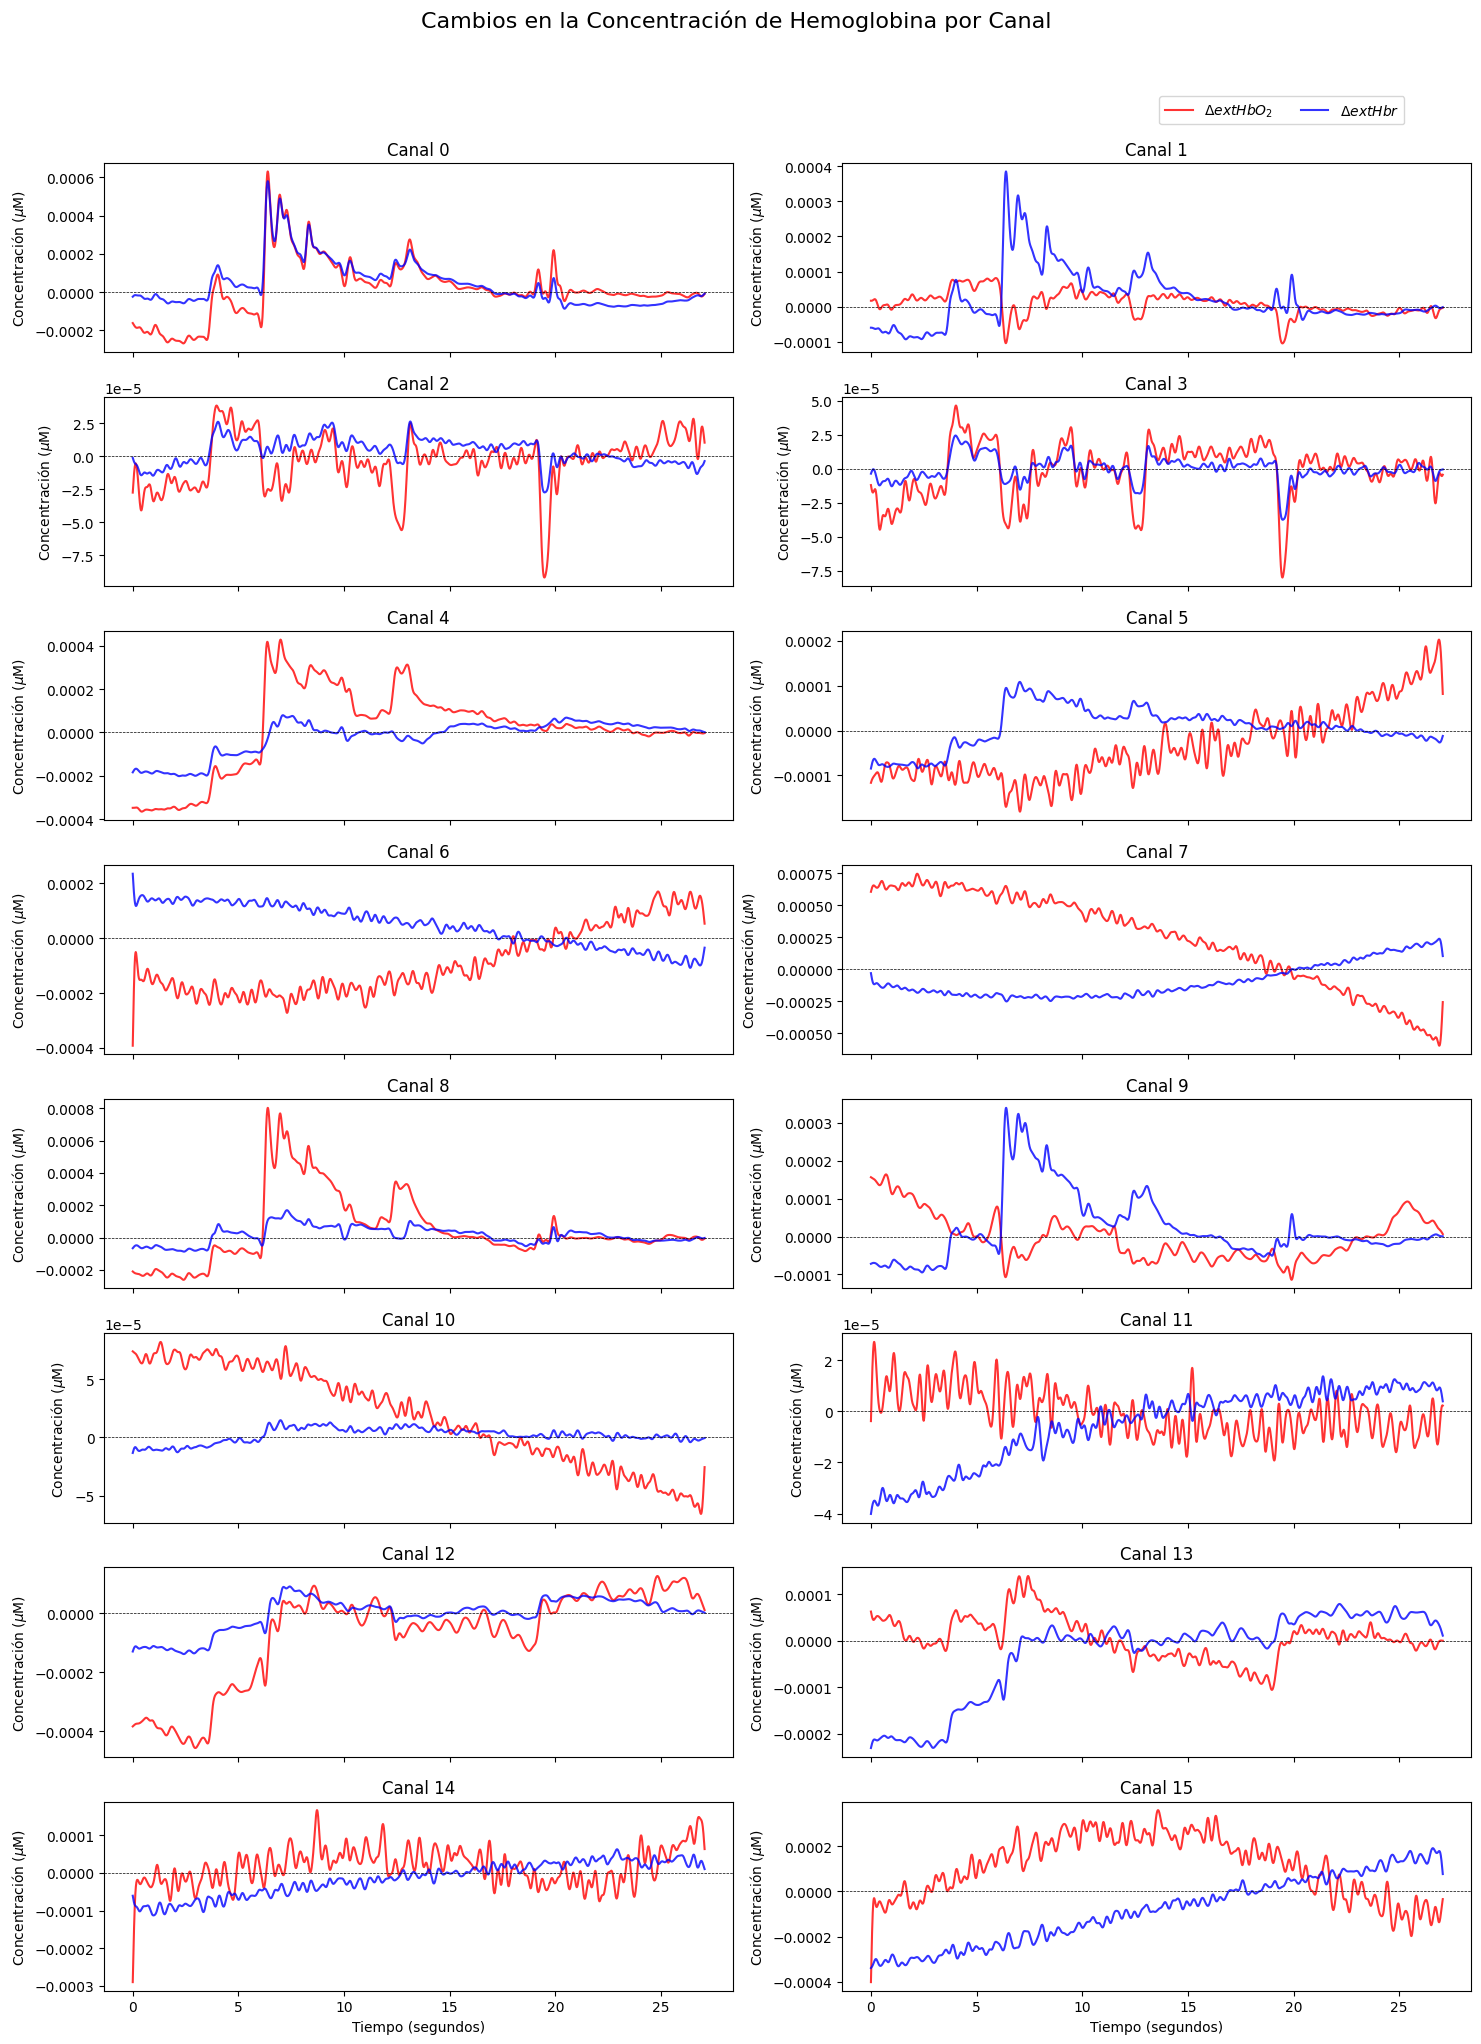

In [46]:
fig, axes = plt.subplots(
    nrows=8,  # 8 filas
    ncols=2,  # 2 columnas (para 16 canales)
    figsize=(15, 20),
    sharex=True 
)
fig.suptitle('Cambios en la Concentración de Hemoglobina por Canal', fontsize=16, y=1.02)
axes = axes.flatten() 

for i, channel in enumerate(channels_to_plot):
    ax = axes[i] 

    # Graficar HbO (en rojo)
    ax.plot(        time_vector,        hbo_data_uM[channel],        label='$\Delta \text{HbO}_2$',        color='r',        alpha=0.8    )

    # Graficar Hbr (en azul)
    ax.plot(
        time_vector,        hbr_data_uM[channel],        label='$\Delta \text{Hbr}$',        color='b',        alpha=0.8    )
    ax.set_title(f'Canal {i}', fontsize=12)
    ax.set_ylabel('Concentración ($\mu$M)')
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5) # Línea en Cero (baseline)

axes[-2].set_xlabel('Tiempo (segundos)')
axes[-1].set_xlabel('Tiempo (segundos)')

fig.legend(
    handles=axes[0].lines,
    labels=['$\Delta \text{HbO}_2$', '$\Delta \text{Hbr}$'],
    loc='upper right',
    bbox_to_anchor=(0.95, 0.98), # Posición de la leyenda
    ncol=2
)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
plt.show()

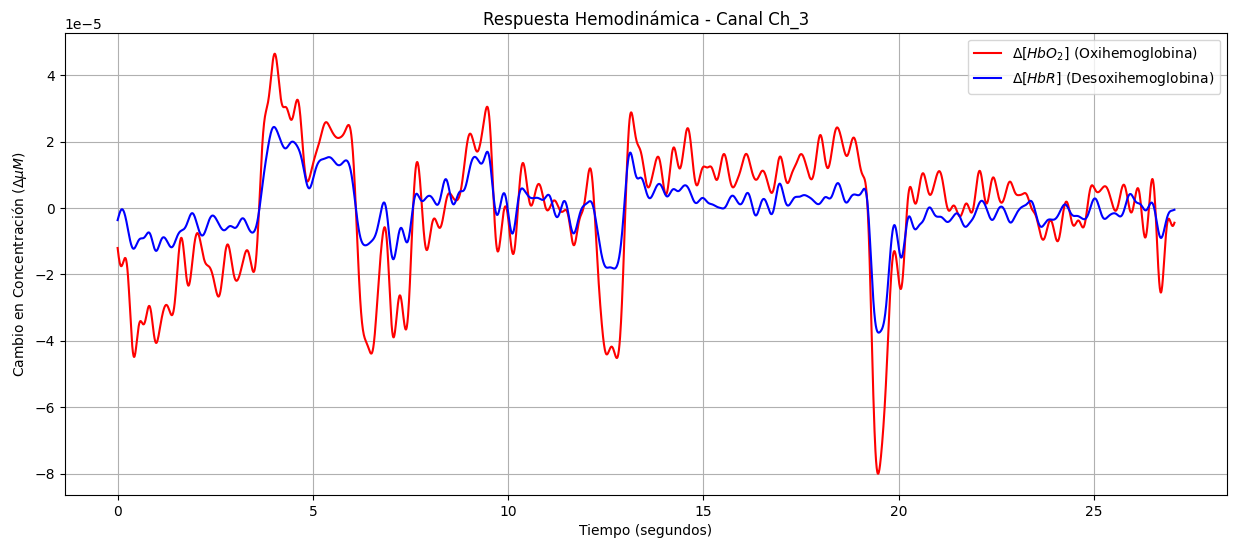

In [47]:
# Elegir un canal a graficar 
channel_to_plot = 'Ch_3'

plt.figure(figsize=(15, 6))
plt.plot(time_vector, hbo_data_uM[channel_to_plot], color='red', label='$\Delta[HbO_2]$ (Oxihemoglobina)')
plt.plot(time_vector, hbr_data_uM[channel_to_plot], color='blue', label='$\Delta[HbR]$ (Desoxihemoglobina)')

plt.title(f"Respuesta Hemodinámica - Canal {channel_to_plot}")
plt.xlabel("Tiempo (segundos)")
plt.ylabel("Cambio en Concentración ($\Delta\mu M$)")
plt.legend()
plt.grid(True)
plt.show()

P1_

In [48]:
# def get_channel_indices(channel_name):
#     """Devuelve los índices de columna RED e IR para un canal dado."""
#     led = CHANNELS_MAP[channel_name]['LED']
#     det = CHANNELS_MAP[channel_name]['DET']
#     base_col = (det - 1) * COLS_PER_DETECTOR
#     red_idx = base_col + (led - 1)
#     ir_idx = base_col + NUM_LED_PAIRS + (led - 1)
#     return red_idx, ir_idx


# def plot_fnirs_channels(raw_data, fs=FS_FNIRS, channels=CHANNELS_MAP.keys(), show_ir=True, show_red=True):
#     time = raw_data.index / fs
#     n_channels = len(channels)
#     fig, axs = plt.subplots(n_channels, 1, figsize=(12, 2.5 * n_channels), sharex=True)

#     if n_channels == 1:
#         axs = [axs]

#     for ax, ch in zip(axs, channels):
#         red_idx, ir_idx = get_channel_indices(ch)
#         if show_red:
#             ax.plot(time, raw_data[red_idx], label='RED', color='crimson')
#         if show_ir:
#             ax.plot(time, raw_data[ir_idx], label='IR', color='navy')
#         ax.set_ylabel(ch)
#         ax.legend(loc='upper right')
#         ax.grid(True)

#     axs[-1].set_xlabel('Tiempo (s)')
#     fig.suptitle('Señales fNIRS crudas por canal', fontsize=16)
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()

# FS_DETECTOR = 128
# FS_FNIRS = 16
# NUM_DETECTORS = 16
# NUM_LED_PAIRS = 8
# COLS_PER_DETECTOR = 2 * NUM_LED_PAIRS  # 16
# TOTAL_COLS_RAW = NUM_DETECTORS * COLS_PER_DETECTOR  # 256


# plot_fnirs_channels(raw_data)